In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ..

C:\Users\penthotal\Desktop\git_repositories\bayesian_ANN


In [11]:
import numpy as np

from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import ShuffleSplit

import pymc3 as pm

import matplotlib.pyplot as plt

from modules.neural_networks import BayesianMLP

# Visualize and Corrupt

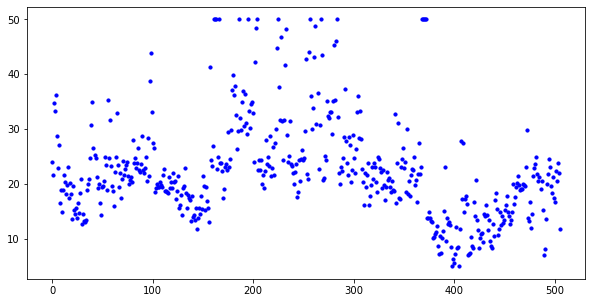

In [15]:
X, y = load_boston(return_X_y=True)

plt.figure(figsize=(10, 5))
plt.scatter(
    [i for i in range(len(y))],
    y,
    s=10,
    c='b'
)
plt.show()

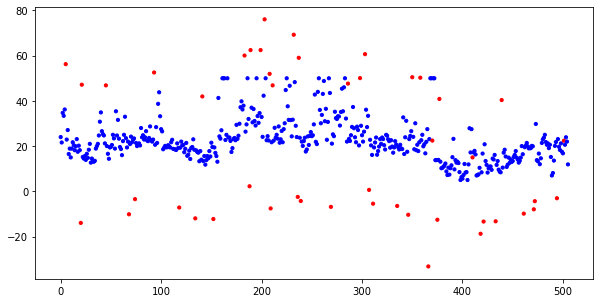

In [14]:
y_std = np.std(y)
random_indices = np.random.choice(
    [i for i in range(len(y))],
    50
)

for index in random_indices:
    
    if np.random.random() < 0.5:
        y[index] -= y_std * 3
    else:
        y[index] += y_std * 3

plt.figure(figsize=(10, 5))
plt.scatter(
    [i for i in range(len(y))],
    y,
    s=10,
    c=['b' if i not in random_indices else 'r' for i in range(len(y))]
)
plt.show()

# Data Preparation

In [16]:
for tr_i, ts_i in ShuffleSplit(n_splits=1).split(X, y):
    
    X_tr, X_ts = X[tr_i], X[ts_i]
    y_tr, y_ts = y[tr_i], y[ts_i]
    
    scaler = MinMaxScaler()
    scaler.fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_ts = scaler.transform(X_ts)

# Gaussian Likelyhood

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


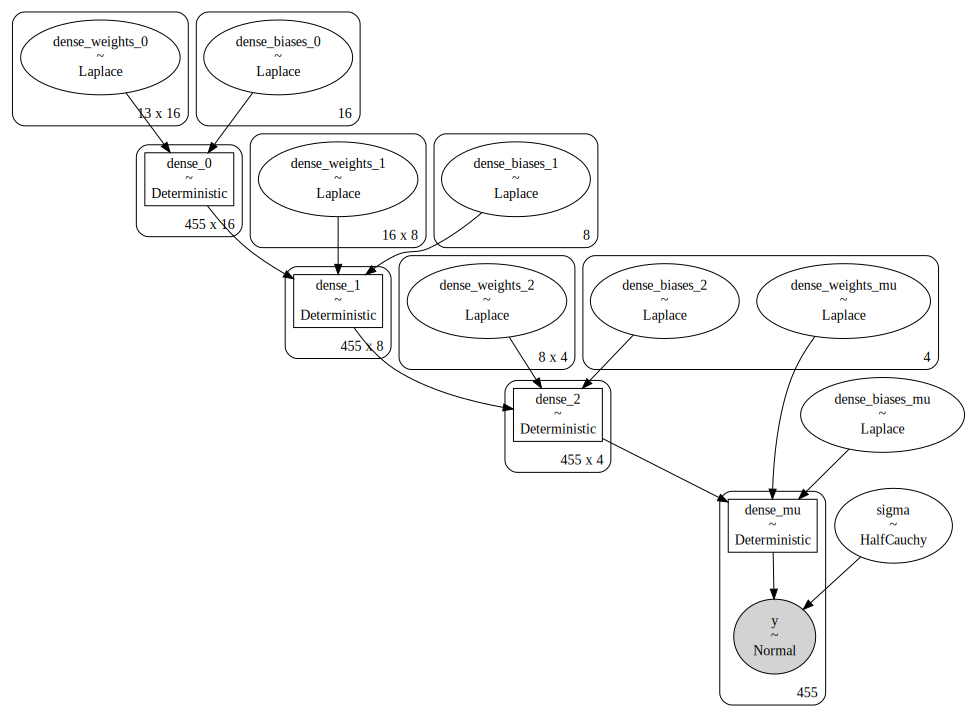

In [17]:
gaussian_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='gaussian_lk',
    layers=(16, 8, 4), 
    activation='tanh',
    batch_size=16,
    prior=pm.Laplace,
    mu=0,
    b=1
)
gaussian_perceptron.show_graph()

In [18]:
gaussian_perceptron.fit(n=500000)
gaussian_traces = gaussian_perceptron.predict(
    X_ts, 
    y_ts,
)

Finished [100%]: Average Loss = 60.696


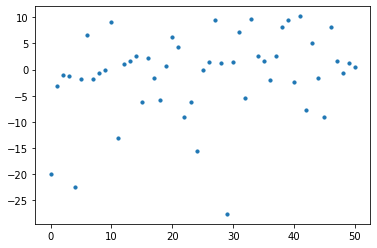

In [20]:
plt.scatter(
    [i for i in range(len(y_ts))], 
    gaussian_traces['y'].mean(0).flatten() - y_ts, 
    s=10
)

# Student-t Likelyhood

C:\Users\penthotal\miniconda3\envs\pr_test_env\lib\site-packages\pymc3\data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


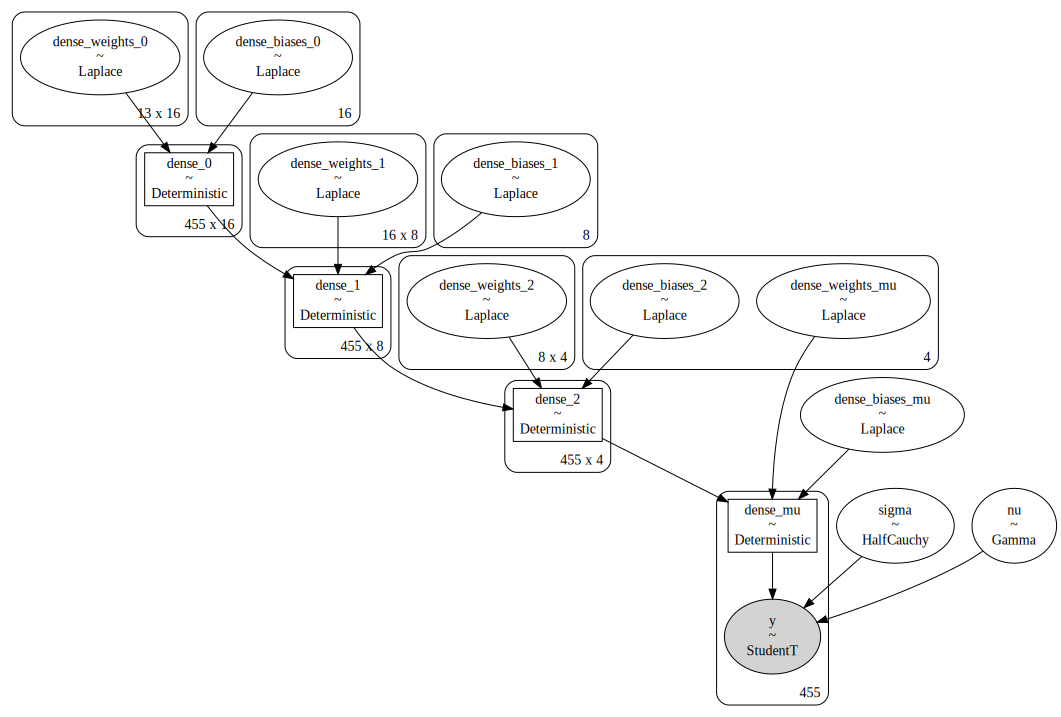

In [8]:
student_perceptron = BayesianMLP(
    X=X_tr, 
    y=y_tr, 
    shape_out=1, 
    likelyhood_model='student_lk',
    layers=(16, 8, 4), 
    activation='tanh',
    batch_size=16,
    prior=pm.Laplace,
    mu=0,
    b=1
)
student_perceptron.show_graph()

In [9]:
student_perceptron.fit(n=500000)
student_traces = student_perceptron.predict(
    X_ts, 
    y_ts, 
    ['y']
)

Finished [100%]: Average Loss = 59.769


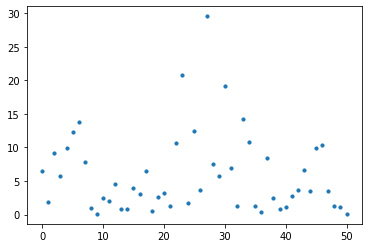

In [10]:
plt.scatter(
    [i for i in range(len(y_ts))], 
    abs(student_traces['y'].mean(0).flatten() - y_ts), 
    s=10
)

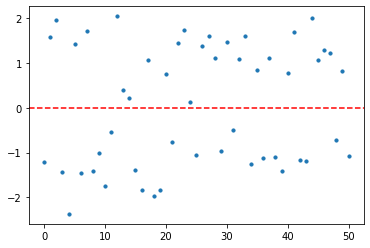

In [11]:
x = abs(student_traces['y'].mean(0).flatten() - y_ts) - abs(gaussian_traces['y'].mean(0).flatten() - y_ts)
plt.scatter([i for i in range(len(y_ts))], x, s=10)
plt.axhline(0, linestyle='--', c='r')